## Author: Denys Herasymuk

**Variant**: the remainder of the division = 3

## Contents of This Notebook

Click on the section and go to this cell immediately.

* [Section 1. Explore Data](#section_1)
* [Section 2. Identifying Stationarity](#section_2)
* [Section 3. Nonstationary-to-Stationary Transformations](#section_3)
* [Section 4. Smoothing Techniques and Models](#section_4)
* [Section 5. Training and Validation ARIMA models](#section_5)
* [Conclusion](#conclusion)


Before running this notebook please run next commands:
* pip install -r requirements.txt

When you use Run All button with this notebook, you should wait approx. 5 mins to get output of all cells.

## General Configuration

In [17]:
import os
import sys
import math
import sklearn
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as ss
import matplotlib.pyplot as plt

from pprint import pprint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [18]:
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# import warnings
# warnings.filterwarnings('ignore')

In [19]:
# Constants
FORECAST_PERIOD = 24
SHIFT = 0

## Python & Library Versions

In [20]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.4
statsmodels 0.12.2
seaborn     0.11.2
sklearn     1.0.2


<a id='section_1'></a>

## Section 1. Explore Data

In [21]:
original_df = pd.read_csv(os.path.join("..", "data", "dataset1_SolarPrediction.csv"))
original_df.head(10)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
5,1475227824,9/29/2016 12:00:00 AM,23:30:24,1.21,48,30.46,64,120.20,5.62,06:13:00,18:13:00
6,1475227519,9/29/2016 12:00:00 AM,23:25:19,1.20,49,30.46,72,112.45,6.75,06:13:00,18:13:00
7,1475227222,9/29/2016 12:00:00 AM,23:20:22,1.24,49,30.46,71,122.97,5.62,06:13:00,18:13:00
8,1475226922,9/29/2016 12:00:00 AM,23:15:22,1.23,49,30.46,80,101.18,4.50,06:13:00,18:13:00
9,1475226622,9/29/2016 12:00:00 AM,23:10:22,1.21,49,30.46,85,141.87,4.50,06:13:00,18:13:00


In [22]:
original_df.shape

(32686, 11)

In [23]:
original_df.columns

Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [24]:
original_df.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

In [25]:
original_df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [26]:
original_df.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [27]:
# area_df.Area_New = area_df.Area_New.interpolate()

## Data Preprocessing

### Transformation for sun duration

In [28]:
datetime_series = original_df.copy()
datetime_series.index = pd.to_datetime(datetime_series['UNIXTime'], unit='s') - datetime.timedelta(
    hours=10)  # also include timezone shift

datetime_series['Sun_Day_Duration'] = pd.to_datetime(datetime_series['TimeSunSet'], format='%H:%M:%S') - \
                                      pd.to_datetime(datetime_series['TimeSunRise'], format='%H:%M:%S')
datetime_series['Sun_Day_Duration'] = round(datetime_series['Sun_Day_Duration'].dt.seconds / 3600, 2)
datetime_series['DateTime'] = datetime_series.index
datetime_series.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Sun_Day_Duration,DateTime
UNIXTime,,,,,,,,,,,,,
2016-09-29 23:55:26,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:55:26
2016-09-29 23:50:23,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:50:23
2016-09-29 23:45:26,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:45:26
2016-09-29 23:40:21,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:40:21
2016-09-29 23:35:24,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:35:24


### UNIX time to datetime transformation

In [29]:
def weekend_transform(row):
    return int(row.dayofweek == 5 or row.dayofweek == 6)

radiation_df = datetime_series.drop(['UNIXTime', 'Data', 'Time'], axis=1)
radiation_df['Year'] = radiation_df.DateTime.dt.year
radiation_df['Month'] = radiation_df.DateTime.dt.month
radiation_df['Day'] = radiation_df.DateTime.dt.day
radiation_df['Hour'] = radiation_df.DateTime.dt.hour
radiation_df['Day_of_week'] = radiation_df.DateTime.dt.dayofweek

radiation_df['Weekend'] = radiation_df['DateTime'].apply(weekend_transform)
radiation_df['Hourly_DateTime'] = pd.to_datetime(
    dict(year=radiation_df.Year, month=radiation_df.Month, day=radiation_df.Day, hour=radiation_df.Hour))
radiation_df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Sun_Day_Duration,DateTime,Year,Month,Day,Hour,Day_of_week,Weekend,Hourly_DateTime
UNIXTime,,,,,,,,,,,,,,,,,
2016-09-29 23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:55:26,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:50:23,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:45:26,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:40:21,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:35:24,2016,9,29,23,3,0,2016-09-29 23:00:00


In [30]:
print(f'Data time range: from {radiation_df.DateTime.unique().min()} to {radiation_df.DateTime.unique().max()}')

Data time range: from 2016-09-01T00:00:08.000000000 to 2016-12-31T23:55:01.000000000


In [31]:
def set_column_types_to_int(df, column_names):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(int)

# Here we take mean of radiation for each hour, since a number of measures during hour can be different for some days what is bad for sum().
# Secondly, sum of radiation is not accurate sum for radiation during each hour
hourly_radiation_df = radiation_df.groupby(['Hourly_DateTime']).mean().copy()
# hourly_radiation_df['Radiation'] = radiation_df.groupby(['Hourly_DateTime'])['Radiation'].sum().copy()
# hourly_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Hourly_DateTime'])['Radiation'].sum().copy())
hourly_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Hourly_DateTime'])['Radiation'].mean().copy())
set_column_types_to_int(hourly_radiation_df, ['Year', 'Month', 'Day', 'Hour', 'Day_of_week', 'Weekend'])
hourly_radiation_df.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sun_Day_Duration,Year,Month,Day,Hour,Day_of_week,Weekend,Log_Radiation
Hourly_DateTime,,,,,,,,,,,,,,
2016-09-01 00:00:00,2.288750,51.125000,30.430000,103.000000,109.837500,8.857500,12.52,2016,9,1,0,3,0,0.828006
2016-09-01 01:00:00,2.943333,51.500000,30.417500,103.000000,121.345833,5.246667,12.52,2016,9,1,1,3,0,1.079543
2016-09-01 02:00:00,2.733333,51.000000,30.404167,103.000000,136.402500,9.653333,12.52,2016,9,1,2,3,0,1.005522
2016-09-01 03:00:00,2.344545,50.818182,30.400000,102.636364,89.257273,5.520909,12.52,2016,9,1,3,3,0,0.852092
2016-09-01 04:00:00,2.607500,49.083333,30.407500,102.000000,118.165833,7.965833,12.52,2016,9,1,4,3,0,0.958392
2016-09-01 05:00:00,1.769000,49.000000,30.412000,97.100000,144.625000,8.435000,12.52,2016,9,1,5,3,0,0.570414
2016-09-01 06:00:00,23.375000,48.900000,30.414000,77.900000,138.292000,8.211000,12.52,2016,9,1,6,3,0,3.151667
2016-09-01 07:00:00,120.567778,50.222222,30.430000,85.333333,108.943333,6.873333,12.52,2016,9,1,7,3,0,4.792212
2016-09-01 08:00:00,464.377500,52.875000,30.450000,80.750000,117.403750,7.450000,12.52,2016,9,1,8,3,0,6.140698


In [32]:
radiation_df['Daily_DateTime'] = pd.to_datetime(
    dict(year=radiation_df.Year, month=radiation_df.Month, day=radiation_df.Day))
daily_radiation_df = radiation_df.groupby(['Daily_DateTime']).mean().copy()
# daily_radiation_df['Radiation'] = radiation_df.groupby(['Daily_DateTime'])['Radiation'].sum().copy()
# daily_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Daily_DateTime'])['Radiation'].sum().copy())
daily_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Daily_DateTime'])['Radiation'].mean().copy())
daily_radiation_df = daily_radiation_df.drop(['Hour'], axis=1)
set_column_types_to_int(daily_radiation_df, ['Year', 'Month', 'Day', 'Day_of_week', 'Weekend'])
daily_radiation_df.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sun_Day_Duration,Year,Month,Day,Day_of_week,Weekend,Log_Radiation
Daily_DateTime,,,,,,,,,,,,,
2016-09-01,298.451600,54.556000,30.436640,78.968000,112.564000,6.396560,12.52,2016,9,1,3,0,5.698608
2016-09-02,333.471219,56.379928,30.446487,72.501792,115.392079,5.804086,12.50,2016,9,2,4,0,5.809557
2016-09-03,123.974574,55.507092,30.438546,94.599291,192.678546,4.960248,12.47,2016,9,3,5,1,4.820076
2016-09-04,153.584321,53.589286,30.454107,93.878571,126.336714,5.184571,12.45,2016,9,4,6,1,5.034250
2016-09-05,306.065125,53.199288,30.419680,79.943060,209.169253,5.830676,12.45,2016,9,5,0,0,5.723798
2016-09-06,310.643781,52.091873,30.403569,75.522968,117.117420,5.499152,12.43,2016,9,6,1,0,5.738647
2016-09-07,151.374677,49.243781,30.423582,69.129353,133.440199,5.023532,12.42,2016,9,7,2,0,5.019758
2016-09-08,25.105563,45.556338,30.407324,80.535211,146.045141,4.806549,12.38,2016,9,8,3,0,3.223089
2016-09-09,19.137236,45.479675,30.373902,97.032520,134.154065,4.497561,12.37,2016,9,9,4,0,2.951636


In [33]:
hourly_radiation_df = hourly_radiation_df[datetime.datetime(2016, 10, 1, 0, 0, 0): datetime.datetime(2016, 11, 29, 0, 0, 0)]
daily_radiation_df = daily_radiation_df[datetime.date(2016, 10, 1): datetime.date(2016, 11, 29)]

<a id='section_2'></a>
## Section 2. Identifying Stationarity

<a id='section_3'></a>
## Section 3. Nonstationary-to-Stationary Transformations

<a id='section_4'></a>
## Section 4. Smoothing Techniques and Models

<a id='section_5'></a>
## Section 5. Training and Validation ARIMA models

In [40]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt
from sklearn.model_selection import TimeSeriesSplit

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr

    return({'1. Mean Absolute Percentage Error (MAPE)':mape,
            '2. Mean Percentage Error (MPE)': mpe,
            '3. Root Mean Squared Error (RMSE)': rmse,
            '4. Mean Error (ME)': me,
            '5. Mean Absolute Error (MAE)': mae,
            '6. Correlation between the Actual and the Forecast (CORR)':corr})


"""def get_train_validate_test_split(time_series):
    ""

    :return: splits on train, validation and test sets based on Cross-Validation
    ""
    n_splits = 3 # Number of train/cv/test folds
    results = []

    trainTestSplit = TimeSeriesSplit(n_splits+1).split(time_series)
    next(trainTestSplit) # Skip the first fold

    for trainCvIndices, testIndices in trainTestSplit:
        # First, we split Train + CV and Test
        XTrainCv = time_series.iloc[trainCvIndices]
        XTest = time_series.iloc[testIndices]

        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
        testLength = len(XTest)
        train = XTrainCv.iloc[0: -testLength-1]
        validate = XTrainCv.iloc[-testLength: -1]

        results.append([train, validate, XTest, XTrainCv])

    return results"""


def get_train_validate_test_split(np_array):
    # end_shift = max(FEATURES_LAGS + RADIATION_LAGS)
    # train_lengths = [177 - end_shift, 189 - end_shift, 201 - end_shift]
    df_length = np_array.shape[0]
    print('df_length -- ', df_length)
    validate_length = FORECAST_PERIOD # also equal to test length
    train_lengths = [df_length - 4 * validate_length, df_length - 3 * validate_length, df_length - 2 * validate_length]

    splits = []
    for train_length in train_lengths:
        train = np_array[: train_length]
        validate = np_array[train_length: train_length + validate_length]
        train_validate = np_array[:train_length + validate_length]
        test = np_array[train_length + validate_length: train_length + 2 * validate_length]

        splits.append((train, validate, test, train_validate))

    return splits


In [35]:
def return_to_initial_series_additive_differencing(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                   model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD
    lag = data_to_return_to_initial_series[stationary_series_name]['lag']

    best_ARMA_model_prediction = best_ARMA_model_prediction.reset_index(drop=True)
    ARMA_model_prediction_initial_series = []

    for i in range(lag):
        ARMA_model_prediction_initial_series.append(OtherPEN_production.Production[len_train_set - lag + i + SHIFT] + best_ARMA_model_prediction[i])

    for i in range(lag, len(best_ARMA_model_prediction)):
        ARMA_model_prediction_initial_series.append(ARMA_model_prediction_initial_series[i - lag] + \
                                                    best_ARMA_model_prediction[i])

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    print('Order (p, d, q) -- ', order_tpl)
    pprint(model_forecast_accuracy)

    if show_plots:
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], 'b--', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', linestyle="--", label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, 'r--', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy


def return_to_initial_series_additive_decomposed(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                 model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD

    if 'additive' in stationary_series_name:
        ARMA_model_prediction_initial_series = best_ARMA_model_prediction.values + \
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + SHIFT: end_idx + SHIFT].values + \
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]
    else:
        ARMA_model_prediction_initial_series = best_ARMA_model_prediction.values * \
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + SHIFT: end_idx + SHIFT].values * \
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    print('Order (p, d, q) -- ', order_tpl)
    pprint(model_forecast_accuracy)

    if show_plots:
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], 'b--', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', linestyle="--", label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, 'r--', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy

In [59]:
def optimize_ARIMA_models(order_list, stationary_series_name, model_name, train_set, validate_set, test_set,
                          train_validate_set, is_ARIMA_model, show_plots, debug_mode):
    """

    Tune AR, MA, ARMA and ARIMA models on validate set and test on test set
    """
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 10_000
    min_RMSE = 1000
    best_model = dict()

    # find the best orders for the model based on validation set
    for order_tpl in order_list:
        print('order_tpl -- ', order_tpl)
        model = ARIMA(train_set, order=order_tpl)
        model_fit = model.fit()
        output = model_fit.predict(start=validate_set.index[0], end=validate_set.index[-1], dynamic=False)

        model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Order (p, d, q) -- ', order_tpl)
            pprint(model_forecast_accuracy)

        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        # if weighted_score <= min_weighted_score and model_forecast_accuracy['3. Root Mean Squared Error (RMSE)'] <= min_RMSE:
        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            min_RMSE = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']
            best_model['(p, d, q)'] = order_tpl
            best_model['prediction'] = output
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots:
        plt.title(f'{model_name} with orders (p, d, q) -- {best_model["(p, d, q)"]}')
        plt.plot(validate_set)
        plt.plot(best_model['prediction'], color='red')
        plt.show()

    # test our model
    model = ARIMA(train_validate_set, order=best_model['(p, d, q)'])
    model_fit = model.fit()

    # added - 1 to predict exactly on 12 months
    prediction = model_fit.predict(start=test_set.index[0], end=test_set.index[0] + FORECAST_PERIOD - 1, dynamic=False)

    if not is_ARIMA_model:
        if 'decomposed' in stationary_series_name:
            best_model_prediction_initial_series, best_model_test_accuracy = \
                return_to_initial_series_additive_decomposed(prediction, len(train_validate_set),
                                                             best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)
        else:
            # if 'multiplicative' in stationary_series_name:
            #     prediction = np.exp(prediction)
            #
            # best_model_prediction_initial_series, best_model_test_accuracy = \
            #     return_to_initial_series_additive_differencing(prediction, len(train_validate_set),
            #                                                    best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)

            # for ARIMA model we should not return to initial series as it can work with our initial non-stationary series
            if 'multiplicative' in stationary_series_name:
                prediction = np.exp(prediction)

            len_train_set = len(train_validate_set)
            start_idx = len_train_set
            end_idx = len_train_set + FORECAST_PERIOD

            model_accuracy = forecast_accuracy(prediction, hourly_radiation_df.Radiation[start_idx: end_idx].to_numpy())
            # model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
            print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
            print('Order (p, d, q) -- ', best_model['(p, d, q)'])
            pprint(model_accuracy)
            best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy
    else:
        # for ARIMA model we should not return to initial series as it can work with our initial non-stationary series
        if 'multiplicative' in stationary_series_name:
            prediction = np.exp(prediction)

        len_train_set = len(train_validate_set)
        start_idx = len_train_set
        end_idx = len_train_set + FORECAST_PERIOD

        model_accuracy = forecast_accuracy(prediction, hourly_radiation_df.Radiation[start_idx: end_idx].to_numpy())
        # model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
        print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
        print('Order (p, d, q) -- ', best_model['(p, d, q)'])
        pprint(model_accuracy)
        best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy

        # if show_plots:
        #     x_indices = range(start_idx, end_idx)
        #
        #     # add + 1 to make consistent plot
        #     plt.plot(OtherPEN_production.Production[:start_idx + 1], 'b--', label="train")
        #     plt.plot(OtherPEN_production.Production[start_idx: end_idx], color='orange', linestyle="--", label="test")
        #     plt.plot(x_indices, best_model_prediction_initial_series, 'r--', label="predictions")
        #     plt.legend(loc='upper left')
        #     plt.title(f'{model_name} {best_model["(p, d, q)"]} Prediction on Test Dataset')
        #     plt.grid(alpha=0.3)
        #     plt.show()

    print('\n' * 8)

    return best_model_prediction_initial_series, best_model['(p, d, q)'], best_model_test_accuracy


def get_best_ARMA_model(stationary_series_name, stationary_split, initial_time_split, show_plots, debug_mode):
    stationary_train_set, stationary_validate_set, stationary_test_set, stationary_train_validate_set = stationary_split
    initial_train_set, initial_validate_set, initial_test_set, initial_train_validate_set = initial_time_split

    # AR_orders = [(p, 0, 0) for p in range(1, 6)]
    # best_AR_model_prediction, AR_model_description, AR_forecast_accuracy = optimize_ARIMA_models(AR_orders, stationary_series_name,
    #                                                                                              'AR Model', stationary_train_set,
    #                                                                                              stationary_validate_set, stationary_test_set,
    #                                                                                              stationary_train_validate_set, False,
    #                                                                                              show_plots, debug_mode)
    #
    # MA_orders = [(0, 0, q) for q in range(1, 4)]
    # best_MA_model_prediction, MA_model_description, MA_forecast_accuracy = optimize_ARIMA_models(MA_orders, stationary_series_name,
    #                                                                                              'MA Model', stationary_train_set,
    #                                                                                              stationary_validate_set, stationary_test_set,
    #                                                                                              stationary_train_validate_set, False,
    #                                                                                              show_plots, debug_mode)

    # ARMA_orders = [(p, 0, q) for p in range(1, 5) for q in range(1, 5)]
    ARMA_orders = [(4, 0, 3)]
    best_ARMA_model_prediction, ARMA_model_description, ARMA_forecast_accuracy = optimize_ARIMA_models(ARMA_orders, stationary_series_name,
                                                                                                       'ARMA Model', stationary_train_set,
                                                                                                       stationary_validate_set, stationary_test_set,
                                                                                                       stationary_train_validate_set, False,
                                                                                                       show_plots, debug_mode)

    # ARIMA_orders = [(p, d, q) for p in range(0, 5) for d in range(1, 3) for q in range(0, 5)]
    # best_ARIMA_model_prediction, ARIMA_model_description, ARIMA_forecast_accuracy = optimize_ARIMA_models(ARIMA_orders, stationary_series_name,
    #                                                                                                       'ARIMA Model', initial_train_set,
    #                                                                                                       initial_validate_set, initial_test_set,
    #                                                                                                       initial_train_validate_set, True,
    #                                                                                                       show_plots, debug_mode)

    best_model = {'model_name': None, 'model_prediction': None, '(p, d, q)': None}
    min_weighted_score = 10_000
    min_RMSE = 1000
    for forecast_accuracy, model_name, model_prediction, model_description in [
        # (AR_forecast_accuracy, 'AR model', best_AR_model_prediction, AR_model_description),
        # (MA_forecast_accuracy, 'MA model', best_MA_model_prediction, MA_model_description),
        (ARMA_forecast_accuracy, 'ARMA model', best_ARMA_model_prediction, ARMA_model_description),
        # (ARIMA_forecast_accuracy, 'ARIMA model', best_ARIMA_model_prediction, ARIMA_model_description)
    ]:
        weighted_score = 0.5 * (forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) + \
                         0.5 * (forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            min_RMSE = forecast_accuracy['3. Root Mean Squared Error (RMSE)']
            best_model['model_name'] = model_name
            best_model['model_prediction'] = model_prediction
            best_model['(p, d, q)'] = model_description

            # TODO: delete in the future
            best_model['1. Mean Absolute Percentage Error (MAPE)'] = forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)']
            best_model['2. Mean Percentage Error (MPE)'] = forecast_accuracy['2. Mean Percentage Error (MPE)']
            best_model['3. Root Mean Squared Error (RMSE)'] = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, stationary_train_validate_set.index[-1]


In [67]:
def test_ARIMA_models(df, stationary_series, initial_time_series, stationary_series_name, show_plots, debug_mode):
    stationary_splits = get_train_validate_test_split(stationary_series)
    initial_time_splits = get_train_validate_test_split(initial_time_series)
    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Orders',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    for i in range(3):
        stationary_split = stationary_splits[i]
        initial_time_split = initial_time_splits[i]

        best_model, last_train_set_idx = get_best_ARMA_model(stationary_series_name, stationary_split, initial_time_split, show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['(p, d, q)'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        # TODO: in progress. SHIFT is not defined
        start_idx = last_train_set_idx
        SHIFT = 0
        end_idx = last_train_set_idx + FORECAST_PERIOD

        print("best_model['model_prediction'] -- ", best_model['model_prediction'])

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(df['Hourly_DateTime'][start_idx + SHIFT + 1 - before_lag: start_idx + SHIFT + 1],
                 df['Radiation'][start_idx + SHIFT + 1 - before_lag: start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(df['Hourly_DateTime'][start_idx + SHIFT: end_idx + SHIFT],
                 df['Radiation'][start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(df['Hourly_DateTime'][start_idx + SHIFT: end_idx + SHIFT],
                 best_model['model_prediction'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["(p, d, q)"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df


### Test additive_decomposed_production stationary series

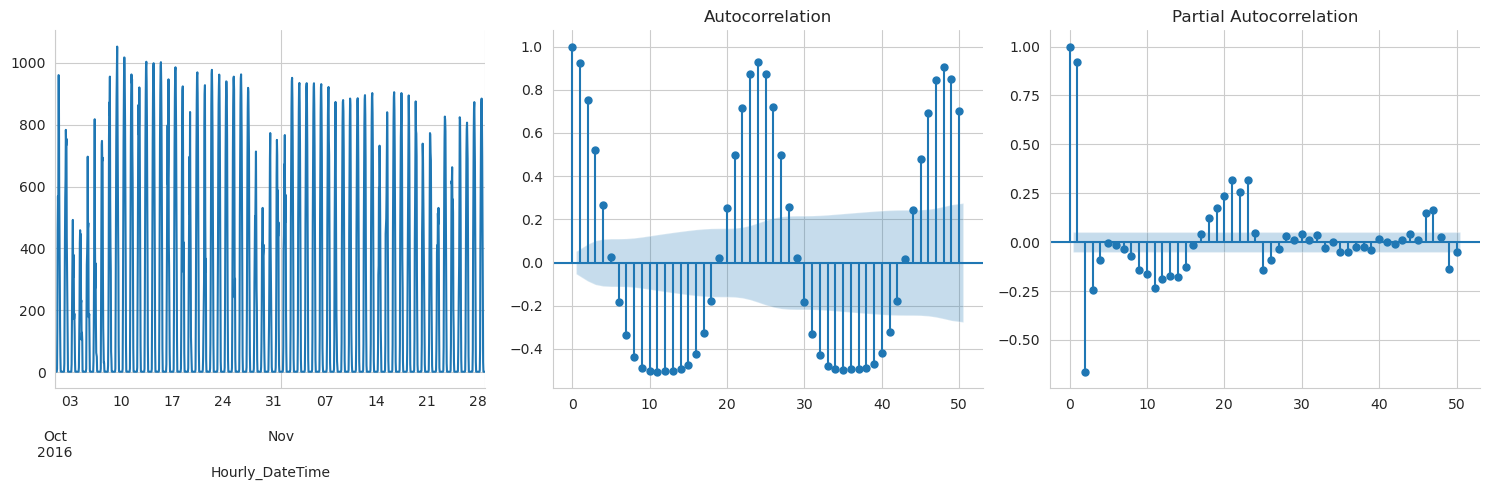

In [68]:
# plots(additive_decomposed_production, lags=50)
plots(hourly_radiation_df.Radiation, lags=50)

In [69]:
hourly_radiation_reset_df = hourly_radiation_df.reset_index()

df_length --  1417
df_length --  1417
############################################################ ARMA Model ############################################################ 


order_tpl --  (4, 0, 3)


 ==================== Forecast Accuracy ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 82.79541891215051,
 '2. Mean Percentage Error (MPE)': 82.51839839023206,
 '3. Root Mean Squared Error (RMSE)': 271.8132598128852,
 '4. Mean Error (ME)': 42.589788226734186,
 '5. Mean Absolute Error (MAE)': 229.148213146455,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.21398487626396107}


/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


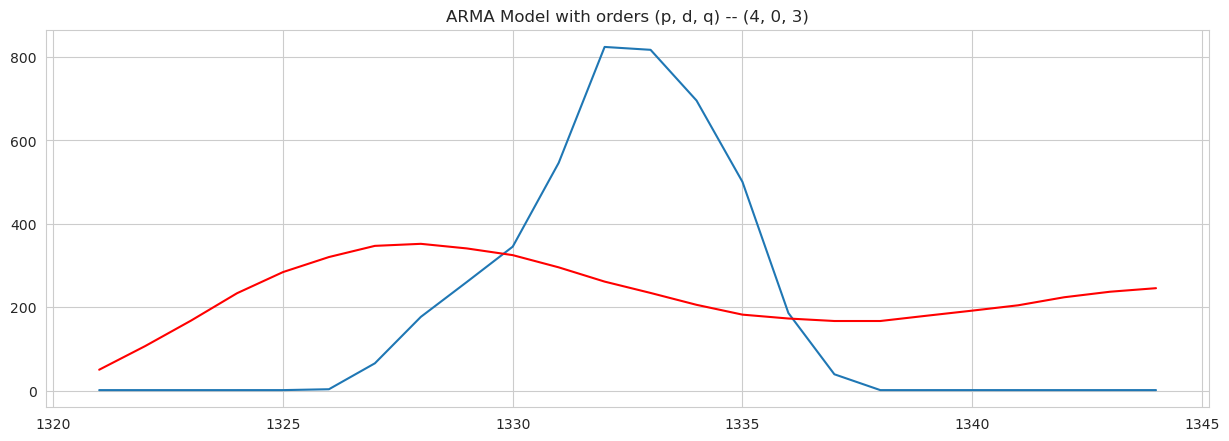

/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 80.20351294098238,
 '2. Mean Percentage Error (MPE)': 79.82148362388487,
 '3. Root Mean Squared Error (RMSE)': 285.9955625980948,
 '4. Mean Error (ME)': -4.0412293104403965,
 '5. Mean Absolute Error (MAE)': 247.80251702148402,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.3967195130978338}









best_model['model_prediction'] --  1345     45.471294
1346    105.871126
1347    161.753664
1348    227.526829
1349    275.731459
1350    311.887765
1351    339.537538
1352    340.246771
1353    337.132310
1354    318.800878
1355    289.348873
1356    266.099954
1357    232.591421
1358    209.108858
1359    192.083037
1360    174.858775
1361    175.238940
1362    174.315230
1363    181.115141
1364    196.471971
1365    204.785982
1366    222.241988
1367    233.846342
1368    240.936850
Name: predicted_mean, dtype: float6

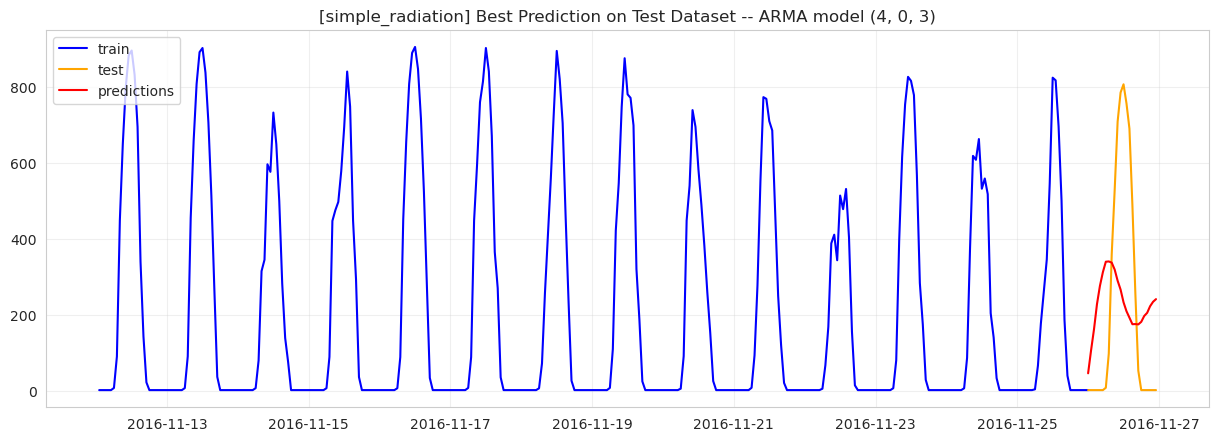

############################################################ ARMA Model ############################################################ 


order_tpl --  (4, 0, 3)


/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)




 ==================== Forecast Accuracy ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 80.20351294098239,
 '2. Mean Percentage Error (MPE)': 79.82148362388486,
 '3. Root Mean Squared Error (RMSE)': 285.9955625980948,
 '4. Mean Error (ME)': -4.041229310440403,
 '5. Mean Absolute Error (MAE)': 247.80251702148402,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.3967195130978338}


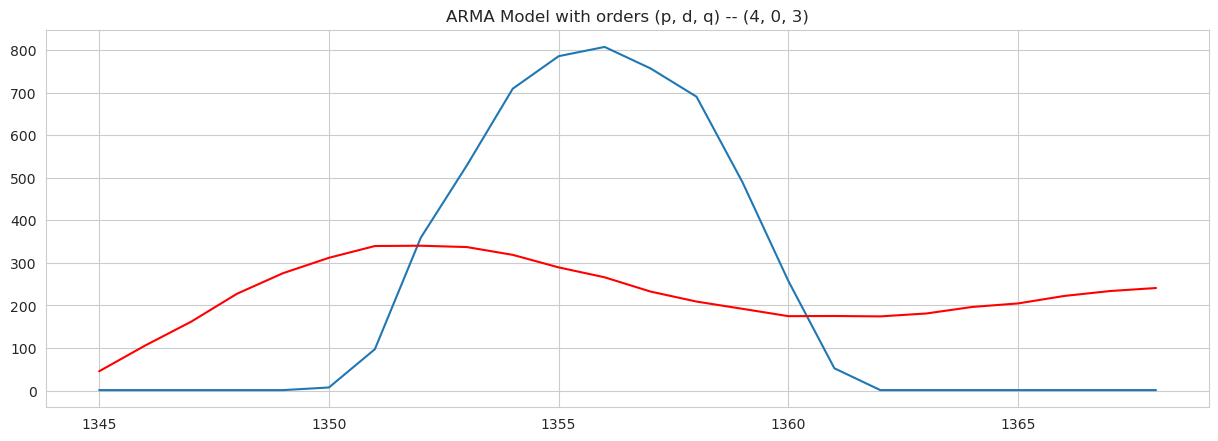

/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 80.2504554736857,
 '2. Mean Percentage Error (MPE)': 79.85927009629931,
 '3. Root Mean Squared Error (RMSE)': 300.5287656512347,
 '4. Mean Error (ME)': -12.727092860337232,
 '5. Mean Absolute Error (MAE)': 258.04835164748283,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.44020825729433377}









best_model['model_prediction'] --  1369     43.864944
1370     98.125160
1371    162.036284
1372    221.570676
1373    273.115875
1374    313.719362
1375    335.677011
1376    344.805639
1377    338.396207
1378    319.492853
1379    295.505480
1380    264.754374
1381    235.998509
1382    210.710175
1383    189.223591
1384    177.745338
1385    171.511532
1386    173.023994
1387    181.530707
1388    191.705521
1389    206.568482
1390    220.417807
1391    232.560775
1392    244.053643
Name: predicted_mean, dtype: float6

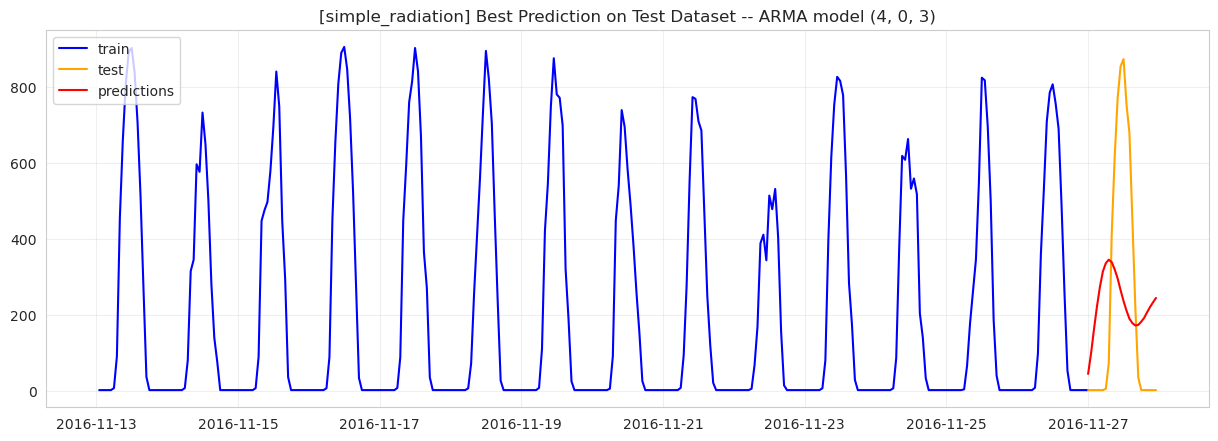

############################################################ ARMA Model ############################################################ 


order_tpl --  (4, 0, 3)


/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'




 ==================== Forecast Accuracy ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 80.2504554736857,
 '2. Mean Percentage Error (MPE)': 79.85927009629933,
 '3. Root Mean Squared Error (RMSE)': 300.5287656512346,
 '4. Mean Error (ME)': -12.727092860337242,
 '5. Mean Absolute Error (MAE)': 258.0483516474828,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.44020825729433377}


/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


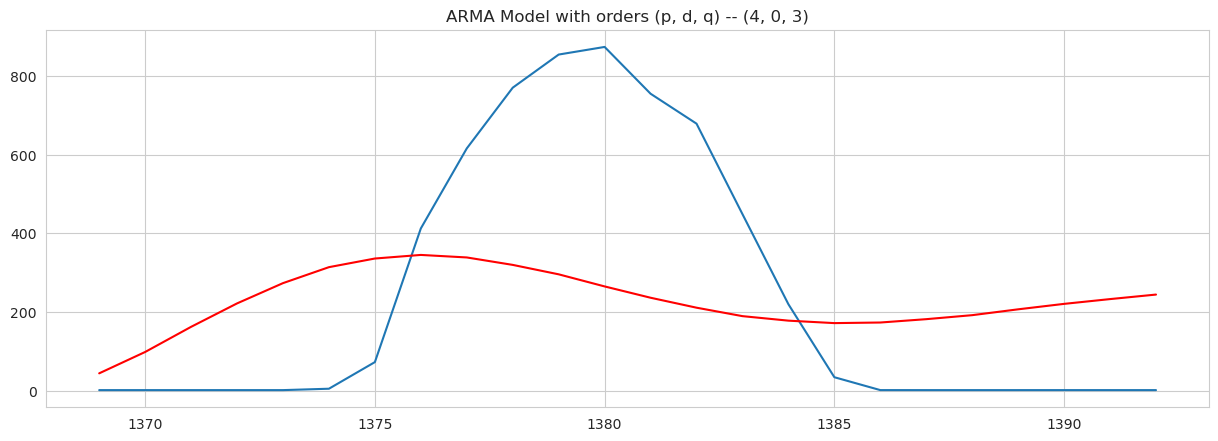

/home/denys_herasymuk/anaconda3/envs/ML_project_env_v1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 79.5443589230962,
 '2. Mean Percentage Error (MPE)': 79.13404513543578,
 '3. Root Mean Squared Error (RMSE)': 311.31938907588614,
 '4. Mean Error (ME)': -22.575036068979628,
 '5. Mean Absolute Error (MAE)': 266.59114019292036,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.42966970294168}









best_model['model_prediction'] --  1393     39.486953
1394     95.900429
1395    159.660580
1396    217.822082
1397    273.265045
1398    311.937674
1399    335.805892
1400    346.615711
1401    338.062531
1402    322.192961
1403    296.500888
1404    265.357893
1405    238.231348
1406    209.940860
1407    190.173348
1408    177.908679
1409    170.247816
1410    173.974046
1411    180.277972
1412    191.611442
1413    207.181146
1414    219.372013
1415    233.865953
1416    244.046706
Name: predicted_mean, dtype: float64


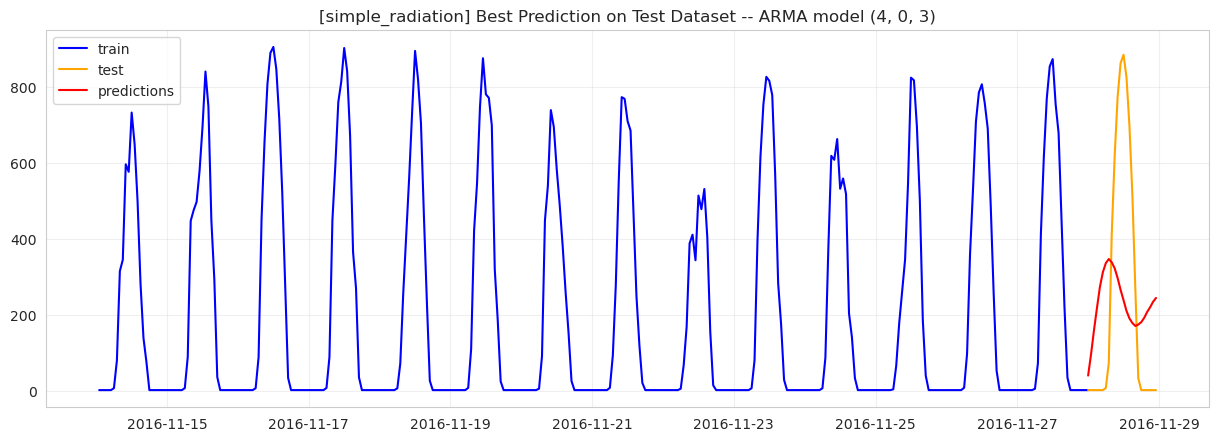

In [70]:
additive_decomposed_production_results_df = test_ARIMA_models(hourly_radiation_reset_df,
                                                              hourly_radiation_reset_df['Radiation'], hourly_radiation_reset_df['Radiation'],
                                                              'simple_radiation',
                                                              show_plots=True, debug_mode=True)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (3, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.07095026298743495,
 '2. Mean Percentage Error (MPE)': 0.025781099147265462,
 '3. Root Mean Squared Error (RMSE)': 14.113340408070234,
 '4. Mean Error (ME)': 3.052040254588858,
 '5. Mean Absolute Error (MAE)': 11.711538839660589,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.891039879170234}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.07648643205718302,
 '2. Mean Percentage Error (MPE)': 0.021539878181835684,
 '3. Root Mean Squared Error (RMS

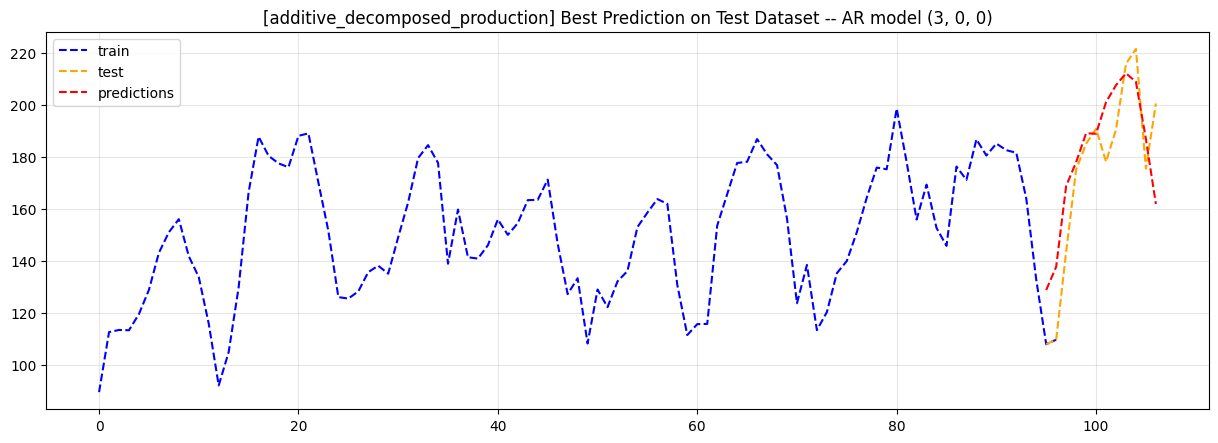

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.06276105668342039,
 '2. Mean Percentage Error (MPE)': -0.03503441658638822,
 '3. Root Mean Squared Error (RMSE)': 20.037453247033508,
 '4. Mean Error (ME)': -8.088240338287155,
 '5. Mean Absolute Error (MAE)': 13.605732486703431,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.7540309011790098}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.06037176720859833,
 '2. Mean Percentage Error (MPE)': -0.032328539379854436,
 '3. Root Mean Squared Error (

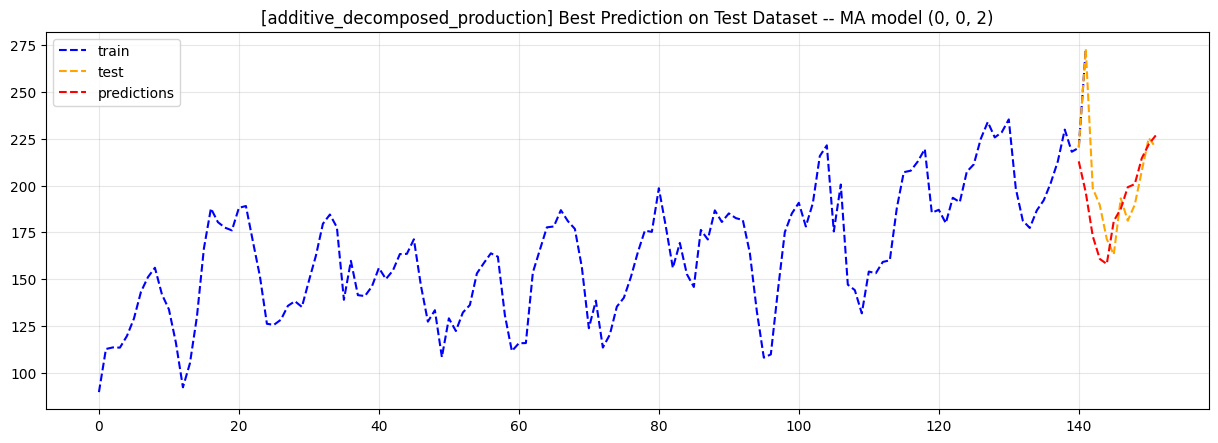

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.04359898839521174,
 '2. Mean Percentage Error (MPE)': -0.020566626565151576,
 '3. Root Mean Squared Error (RMSE)': 10.533566276563123,
 '4. Mean Error (ME)': -5.30514126023196,
 '5. Mean Absolute Error (MAE)': 9.150609951404,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9757292158831478}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.06326915351925687,
 '2. Mean Percentage Error (MPE)': -0.02878108429722487,
 '3. Root Mean Squared Error (RMSE)

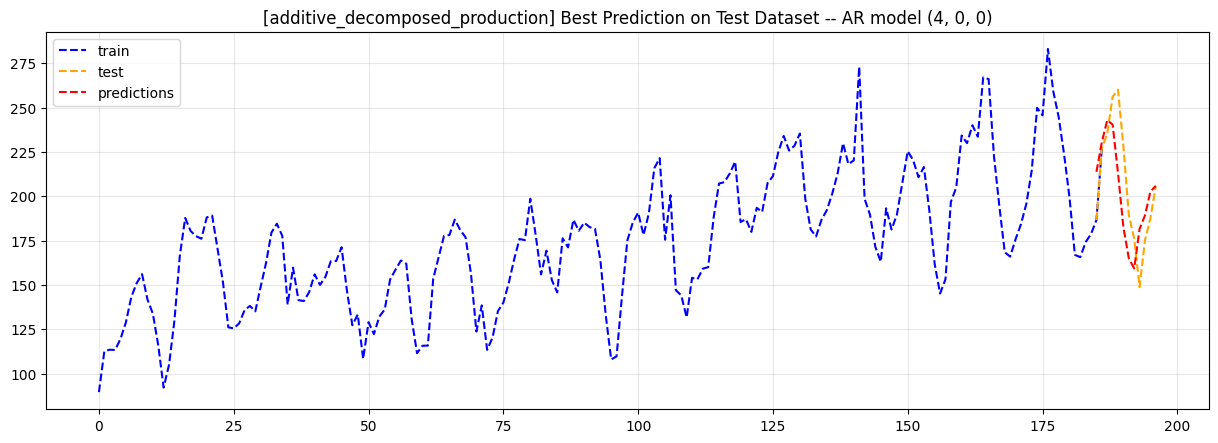

In [808]:
additive_decomposed_production_results_df = test_ARIMA_models(additive_decomposed_production, OtherPEN_production.Production, 'additive_radiation',
                                                              show_plots=False, debug_mode=False)

### Test multiplicative_decomposed_production stationary series

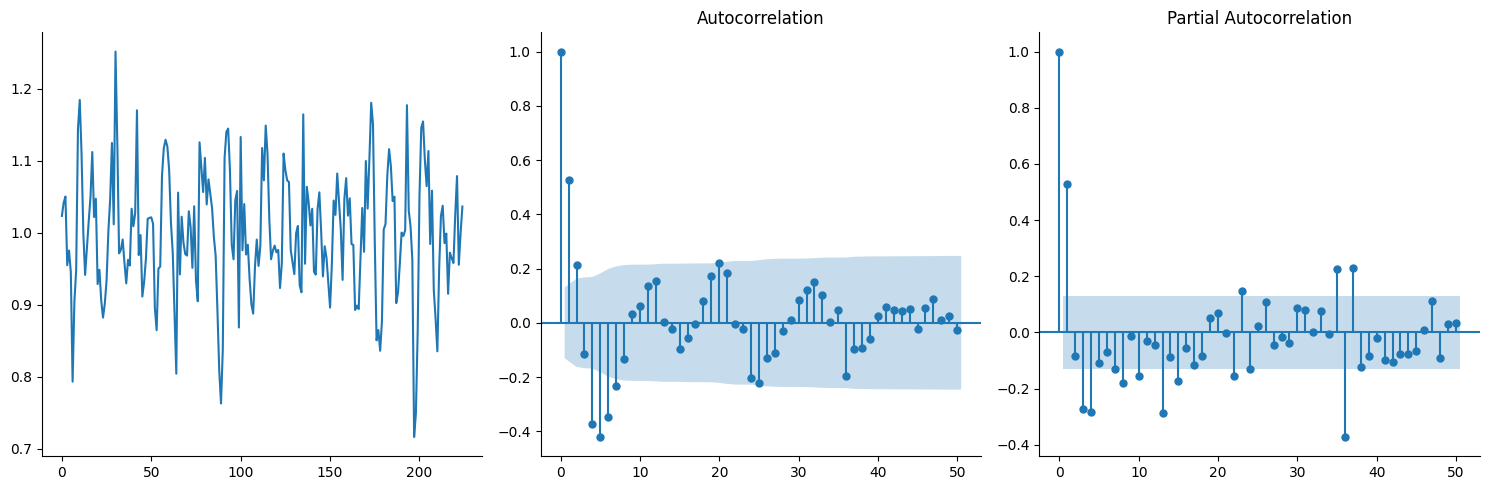

In [809]:
plots(multiplicative_decomposed_production, lags=50)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (3, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.06870078543904673,
 '2. Mean Percentage Error (MPE)': 0.026452208789479376,
 '3. Root Mean Squared Error (RMSE)': 13.851598175518799,
 '4. Mean Error (ME)': 3.3063975475705143,
 '5. Mean Absolute Error (MAE)': 11.365747374681867,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.896133787111175}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.07449456195389627,
 '2. Mean Percentage Error (MPE)': 0.020496488108844912,
 '3. Root Mean Squared Error (RM

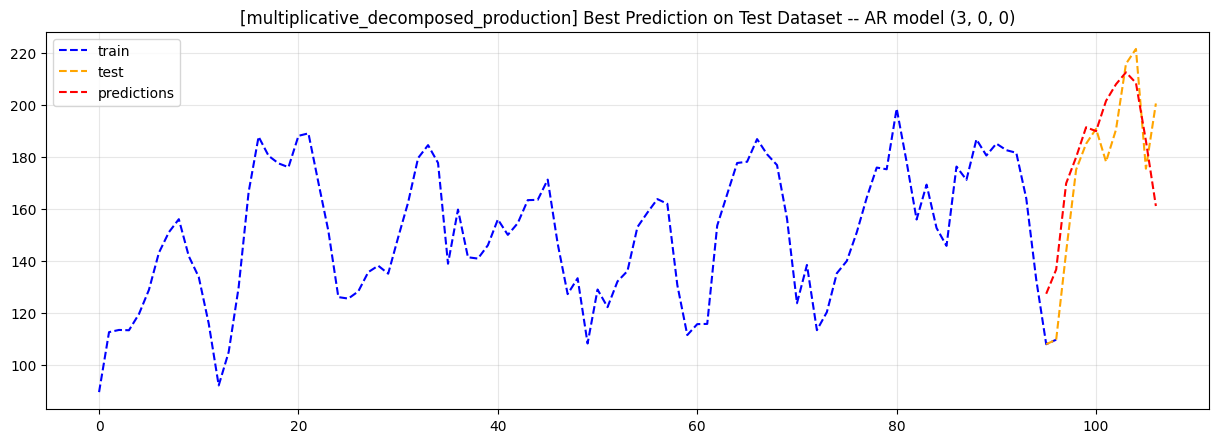

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.061466177263103376,
 '2. Mean Percentage Error (MPE)': -0.02866572943054874,
 '3. Root Mean Squared Error (RMSE)': 20.167630055199965,
 '4. Mean Error (ME)': -6.943731275869574,
 '5. Mean Absolute Error (MAE)': 13.49803725272737,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.734302382265275}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.06663875427194087,
 '2. Mean Percentage Error (MPE)': -0.03242210203765202,
 '3. Root Mean Squared Error (RM

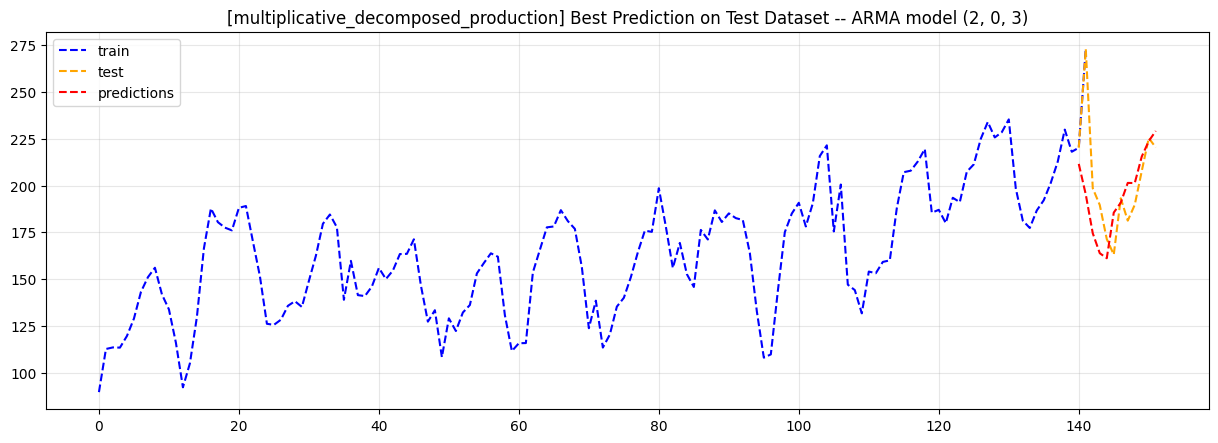

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.03946622937736335,
 '2. Mean Percentage Error (MPE)': -0.018687064012214694,
 '3. Root Mean Squared Error (RMSE)': 9.66663065618251,
 '4. Mean Error (ME)': -4.367579246708338,
 '5. Mean Absolute Error (MAE)': 8.063424547995153,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9657027997469257}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.05980876482318661,
 '2. Mean Percentage Error (MPE)': -0.02975362716879366,
 '3. Root Mean Squared Error (RMS

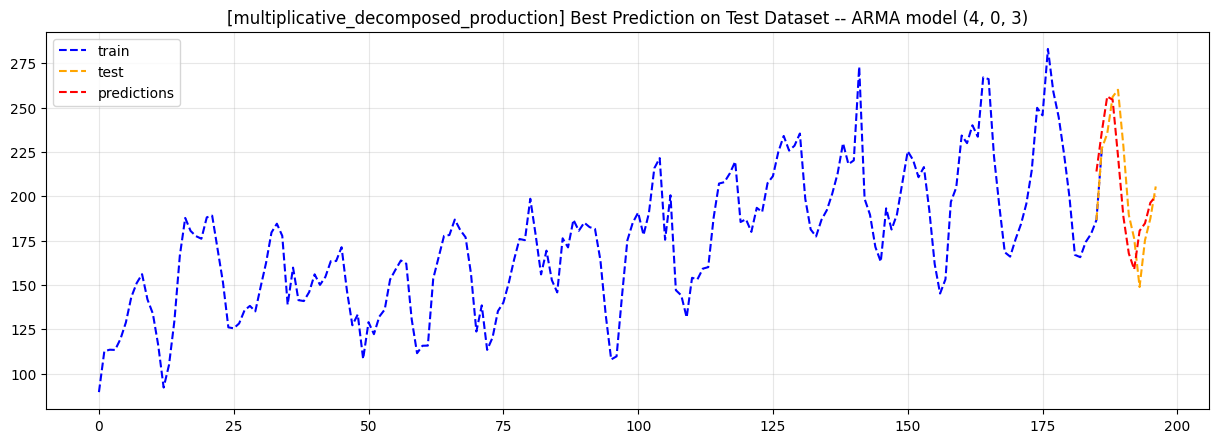

In [810]:
multiplicative_decomposed_production_results_df = test_ARIMA_models(multiplicative_decomposed_production, OtherPEN_production.Log_production,
                                                                    'multiplicative_decomposed_production', show_plots=False, debug_mode=False)

### Test additive_diff_production_1 stationary series

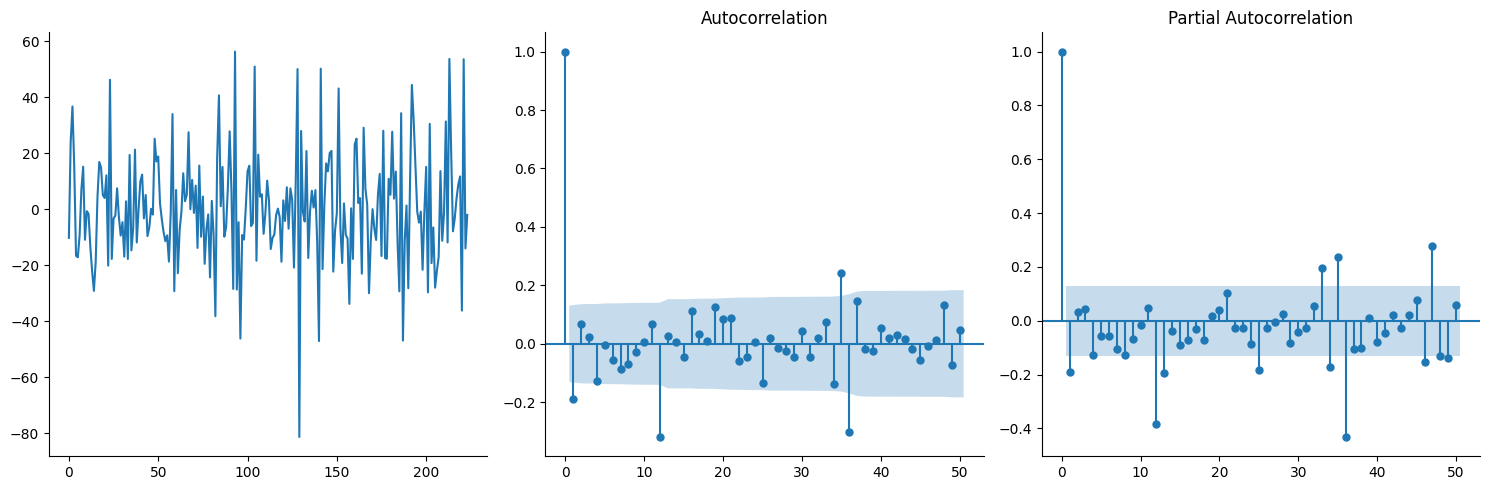

In [811]:
plots(additive_diff_production_1, lags=50)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.18725855899445085,
 '2. Mean Percentage Error (MPE)': -0.15122483207046533,
 '3. Root Mean Squared Error (RMSE)': 41.147161050068064,
 '4. Mean Error (ME)': -30.84219479500432,
 '5. Mean Absolute Error (MAE)': 35.74231452816795,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.45210434919454795}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.19207562443281298,
 '2. Mean Percentage Error (MPE)': -0.1654030034094547,
 '3. Root Mean Squared Error (R

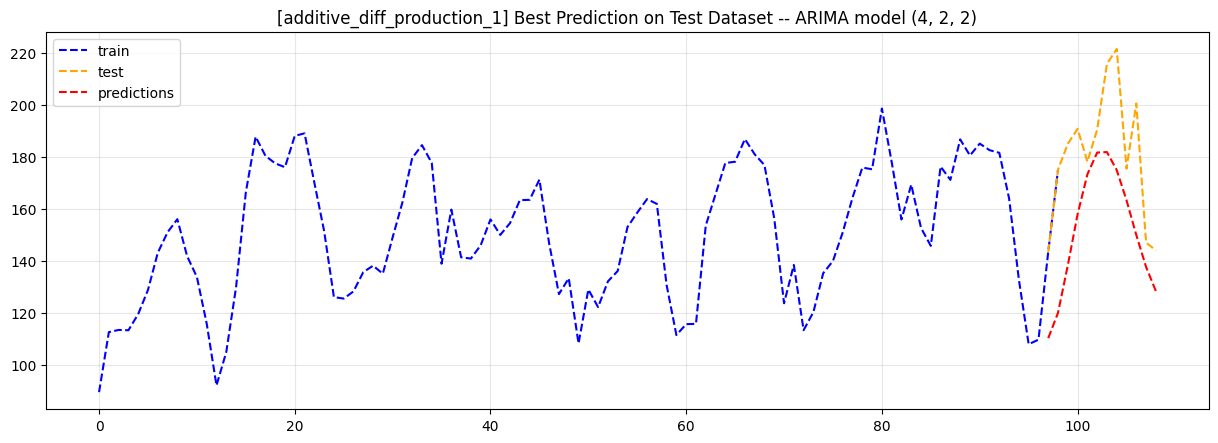

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.39410721652494535,
 '2. Mean Percentage Error (MPE)': 0.39410721652494535,
 '3. Root Mean Squared Error (RMSE)': 77.54118001996152,
 '4. Mean Error (ME)': 75.18970795598064,
 '5. Mean Absolute Error (MAE)': 75.18970795598064,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.69773812197943}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.3965209018580307,
 '2. Mean Percentage Error (MPE)': 0.3965209018580307,
 '3. Root Mean Squared Error (RMSE)': 7

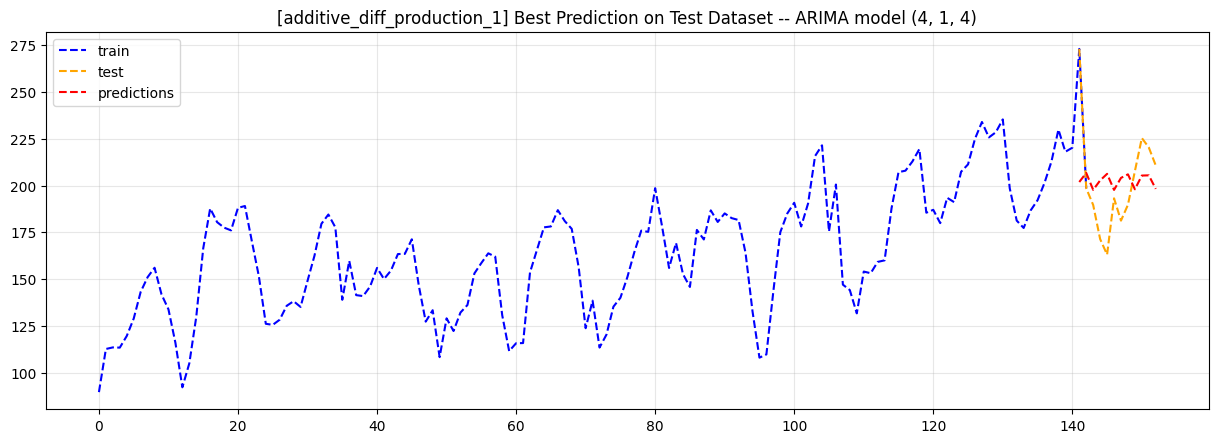

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (3, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.14547365102835505,
 '2. Mean Percentage Error (MPE)': -0.09188574559553865,
 '3. Root Mean Squared Error (RMSE)': 40.30619672666165,
 '4. Mean Error (ME)': -23.839347539895048,
 '5. Mean Absolute Error (MAE)': 32.21551491916593,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.6424995711035624}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.14427391778853763,
 '2. Mean Percentage Error (MPE)': -0.08901149480357208,
 '3. Root Mean Squared Error (RM

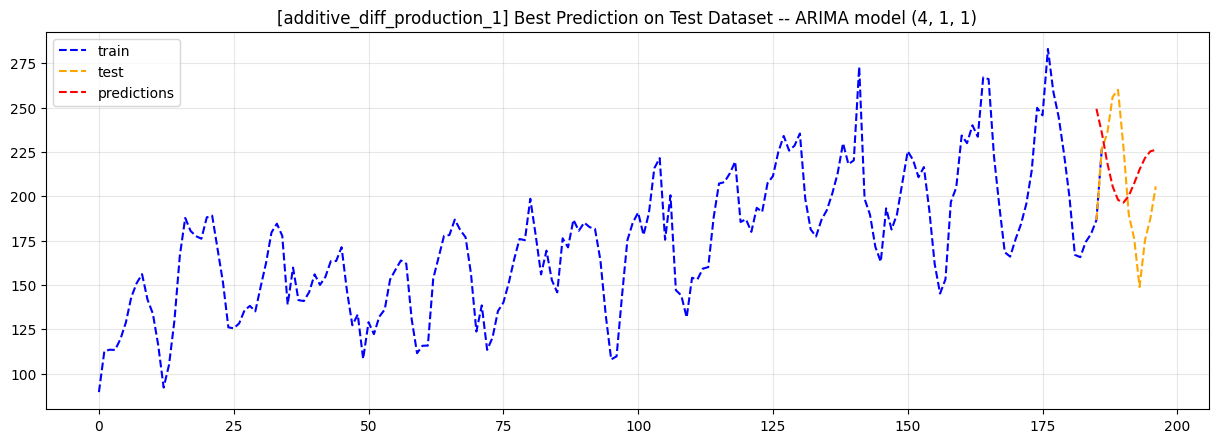

In [812]:
additive_diff_production_1_results_df = test_ARIMA_models(additive_diff_production_1, OtherPEN_production.Production, 'additive_diff_production_1',
                                                           show_plots=False, debug_mode=False)

### Test multiplicative_diff_production_1 stationary series

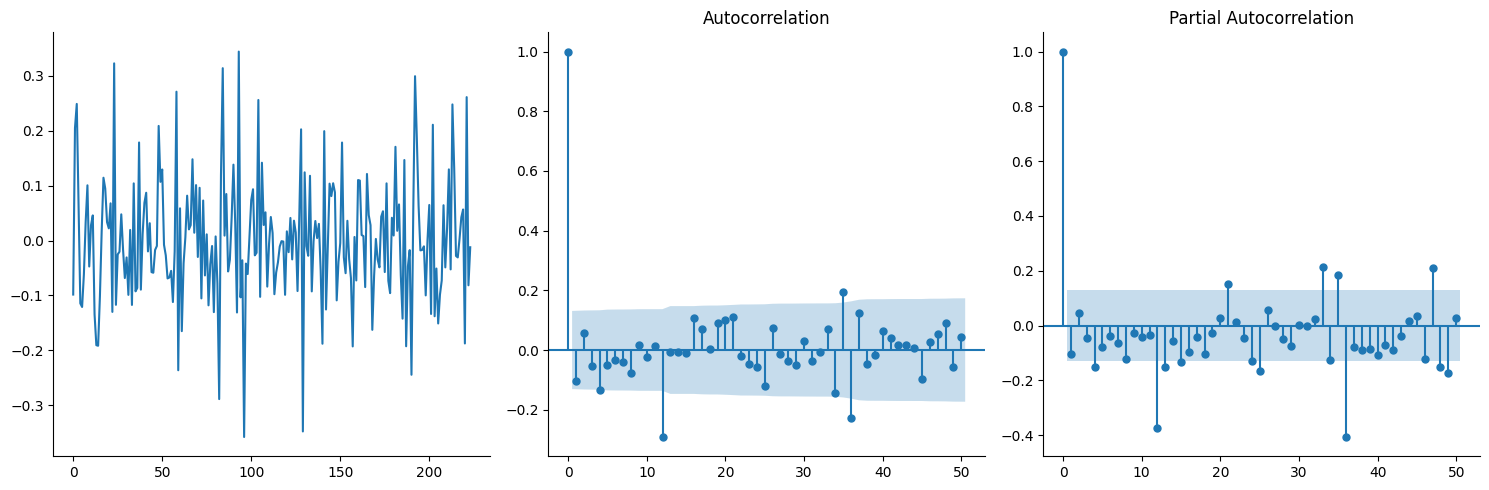

In [813]:
plots(multiplicative_diff_production_1, lags=50)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.192668959337327,
 '2. Mean Percentage Error (MPE)': -0.14327659906200493,
 '3. Root Mean Squared Error (RMSE)': 41.00580241618137,
 '4. Mean Error (ME)': -29.63007729750504,
 '5. Mean Absolute Error (MAE)': 36.398860447235,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.49268401037199483}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.19261452395318265,
 '2. Mean Percentage Error (MPE)': -0.14304299764807518,
 '3. Root Mean Squared Error (RMSE)

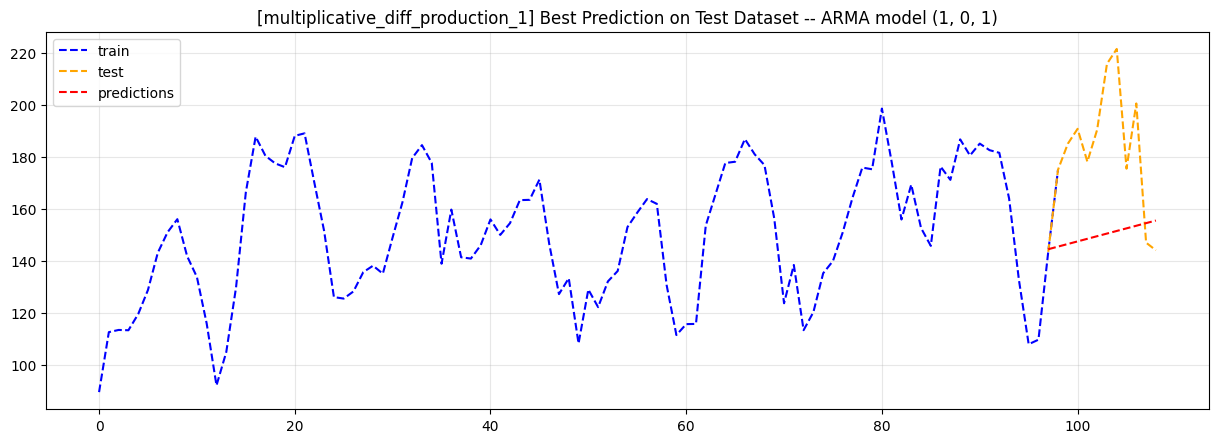

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4285811167185565,
 '2. Mean Percentage Error (MPE)': 0.4285811167185565,
 '3. Root Mean Squared Error (RMSE)': 83.81475594204943,
 '4. Mean Error (ME)': 82.17999216534132,
 '5. Mean Absolute Error (MAE)': 82.17999216534132,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.7044249923294603}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4285849139705061,
 '2. Mean Percentage Error (MPE)': 0.4285849139705061,
 '3. Root Mean Squared Error (RMSE)': 83

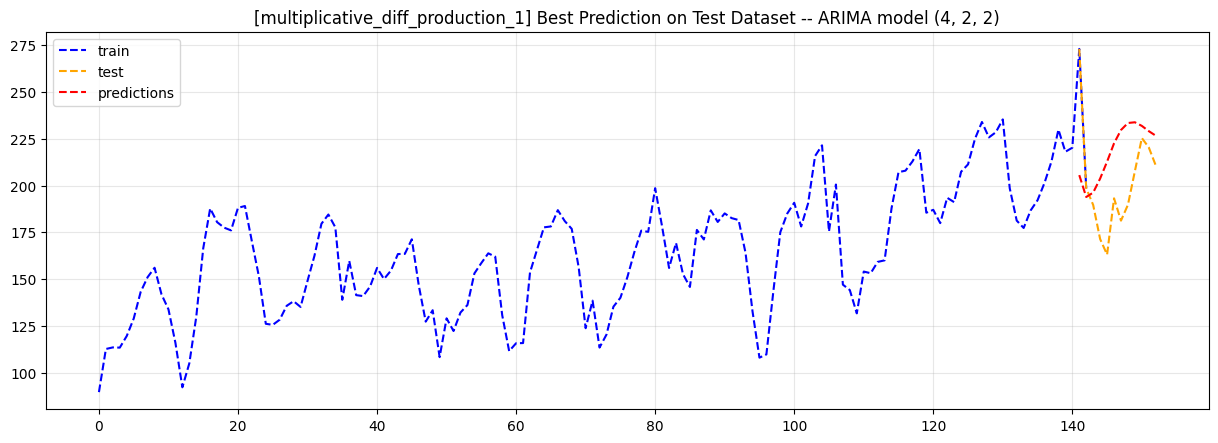

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.14145892056441556,
 '2. Mean Percentage Error (MPE)': -0.04350678436495576,
 '3. Root Mean Squared Error (RMSE)': 37.91012612251865,
 '4. Mean Error (ME)': -14.42155274289586,
 '5. Mean Absolute Error (MAE)': 30.39183355012779,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.626847840463396}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.1414585983547553,
 '2. Mean Percentage Error (MPE)': -0.0435026806517361,
 '3. Root Mean Squared Error (RMSE)

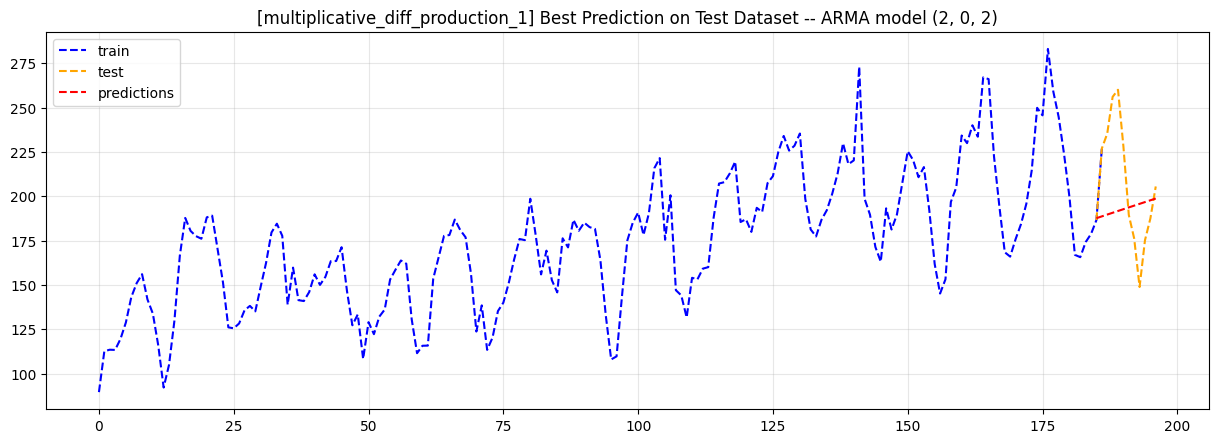

In [814]:
multiplicative_diff_production_1_results_df = test_ARIMA_models(multiplicative_diff_production_1, OtherPEN_production.Log_production,
                                                                'multiplicative_diff_production_1', show_plots=False, debug_mode=False)

### Test additive_diff_production_12 stationary series

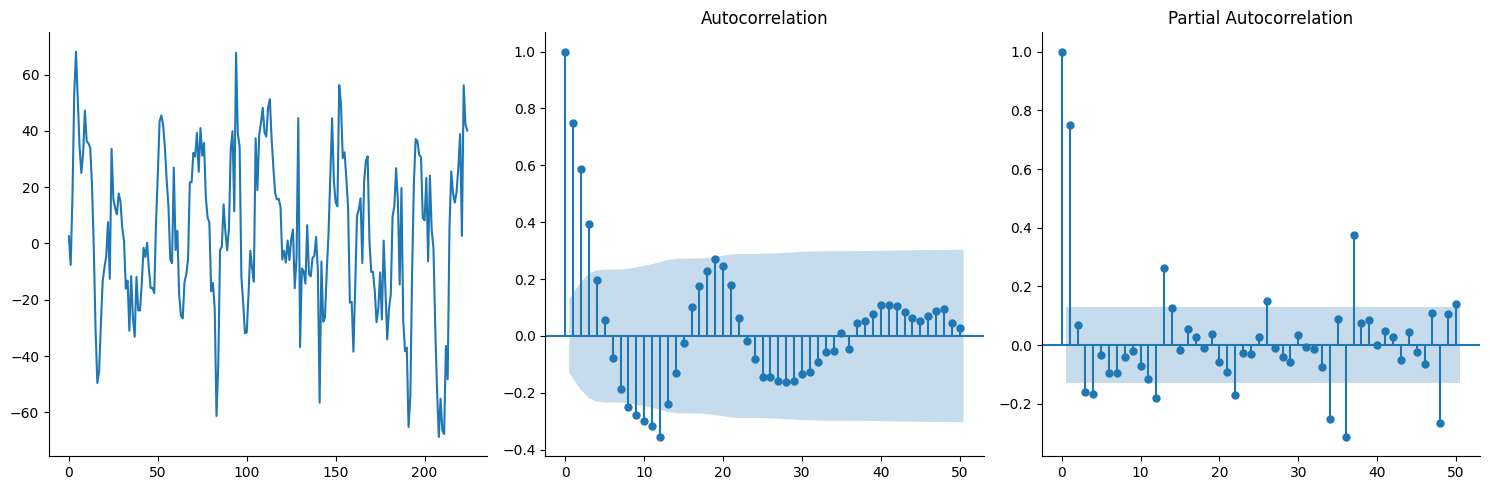

In [815]:
plots(additive_diff_production_12, lags=50)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.11956333446977281,
 '2. Mean Percentage Error (MPE)': -0.04711808704132244,
 '3. Root Mean Squared Error (RMSE)': 28.276420523530316,
 '4. Mean Error (ME)': -11.672723503926496,
 '5. Mean Absolute Error (MAE)': 20.150560064169003,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.5661654721529554}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.11332678498951909,
 '2. Mean Percentage Error (MPE)': -0.04251771789997649,
 '3. Root Mean Squared Error (

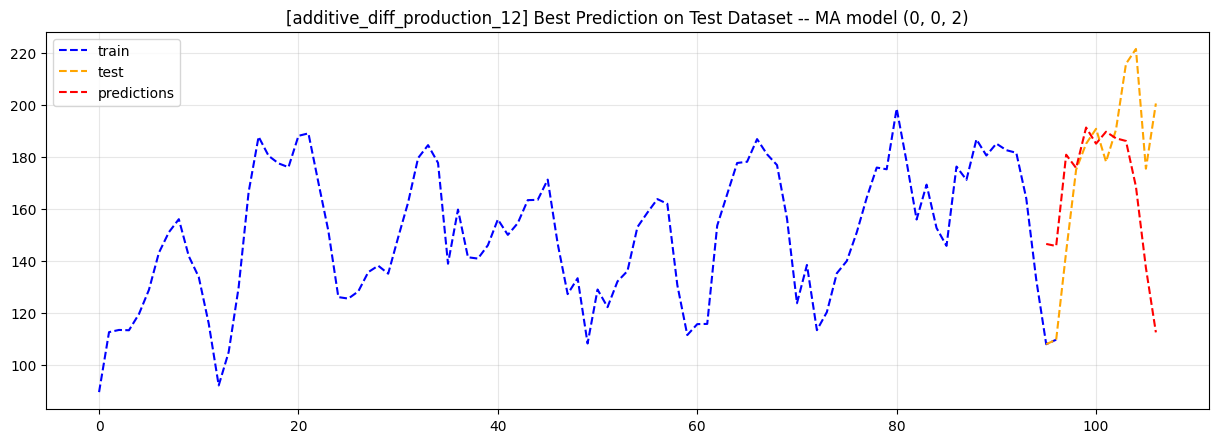

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.08951921007642827,
 '2. Mean Percentage Error (MPE)': 0.06639907473136684,
 '3. Root Mean Squared Error (RMSE)': 21.473145209642695,
 '4. Mean Error (ME)': 11.721602766246379,
 '5. Mean Absolute Error (MAE)': 18.033399715448148,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.7673945177116039}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.08953781451318282,
 '2. Mean Percentage Error (MPE)': 0.06752374571609014,
 '3. Root Mean Squared Error (RMS

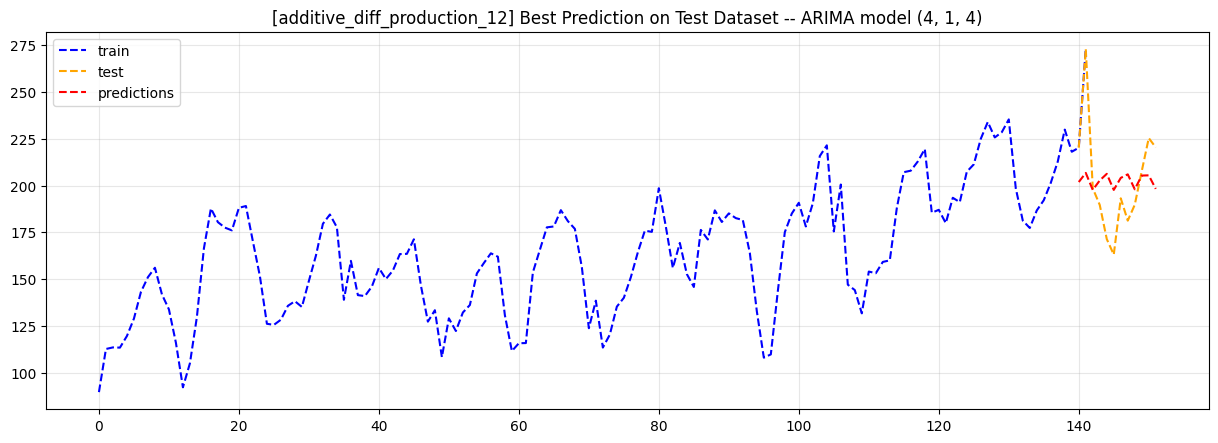

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.07230725125741712,
 '2. Mean Percentage Error (MPE)': 0.012870047265346421,
 '3. Root Mean Squared Error (RMSE)': 16.228840053048568,
 '4. Mean Error (ME)': 1.886934774713789,
 '5. Mean Absolute Error (MAE)': 14.109230963346192,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.8806171049586557}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.08288392564386639,
 '2. Mean Percentage Error (MPE)': 0.04572640716923141,
 '3. Root Mean Squared Error (RMS

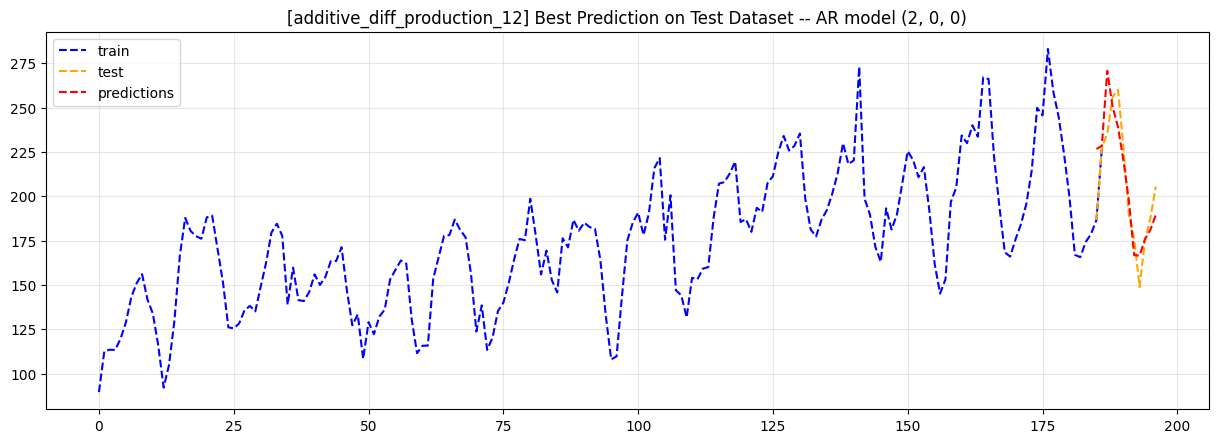

In [816]:
additive_diff_production_12_results_df = test_ARIMA_models(additive_diff_production_12, OtherPEN_production.Production, 'additive_diff_production_12',
                                                           show_plots=False, debug_mode=False)

### Test multiplicative_diff_production_12 stationary series

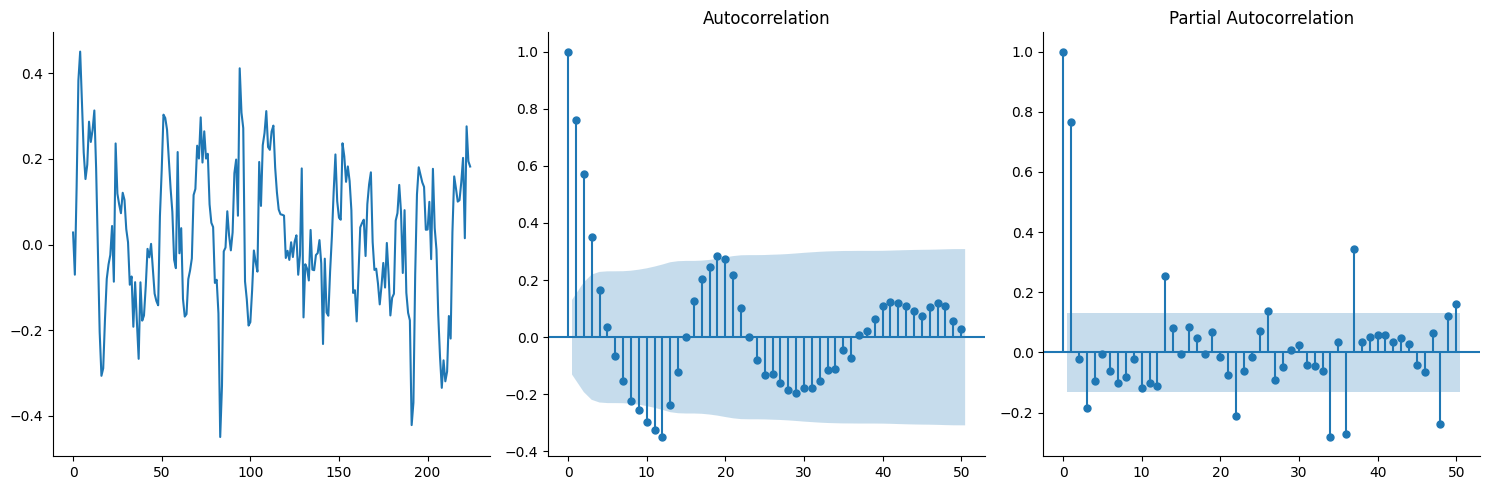

In [817]:
plots(multiplicative_diff_production_12, lags=50)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.12808506060207833,
 '2. Mean Percentage Error (MPE)': -0.05234143938602822,
 '3. Root Mean Squared Error (RMSE)': 29.841362038178328,
 '4. Mean Error (ME)': -12.79067908215059,
 '5. Mean Absolute Error (MAE)': 21.595086930852492,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.5220209046538211}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 0.12813336243307014,
 '2. Mean Percentage Error (MPE)': -0.05221326692187711,
 '3. Root Mean Squared Error (R

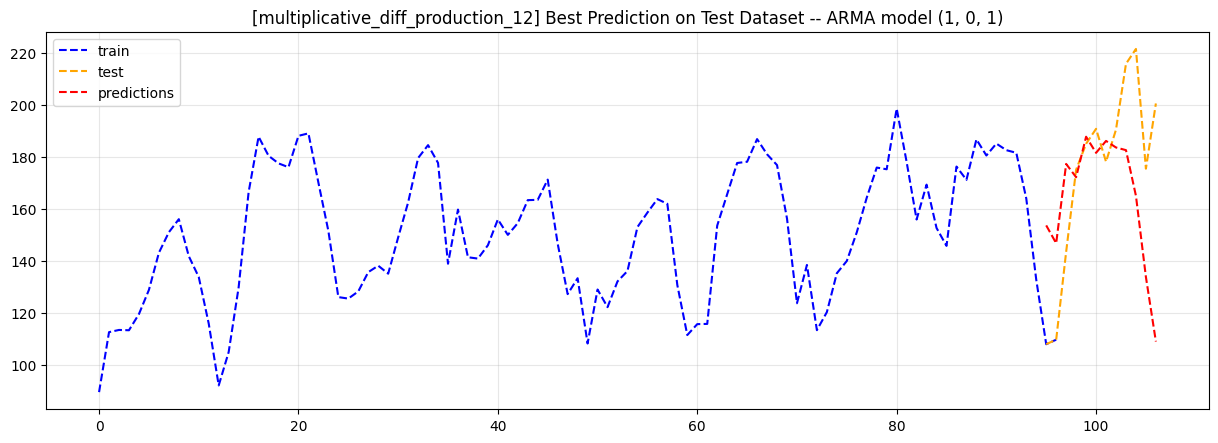

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.0692221464965407,
 '2. Mean Percentage Error (MPE)': 0.03702711173807228,
 '3. Root Mean Squared Error (RMSE)': 18.901443160928988,
 '4. Mean Error (ME)': 5.8920603200817325,
 '5. Mean Absolute Error (MAE)': 14.255419466588249,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.7683837613953479}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.06922673316819668,
 '2. Mean Percentage Error (MPE)': 0.03704492121359944,
 '3. Root Mean Squared Error (RMSE

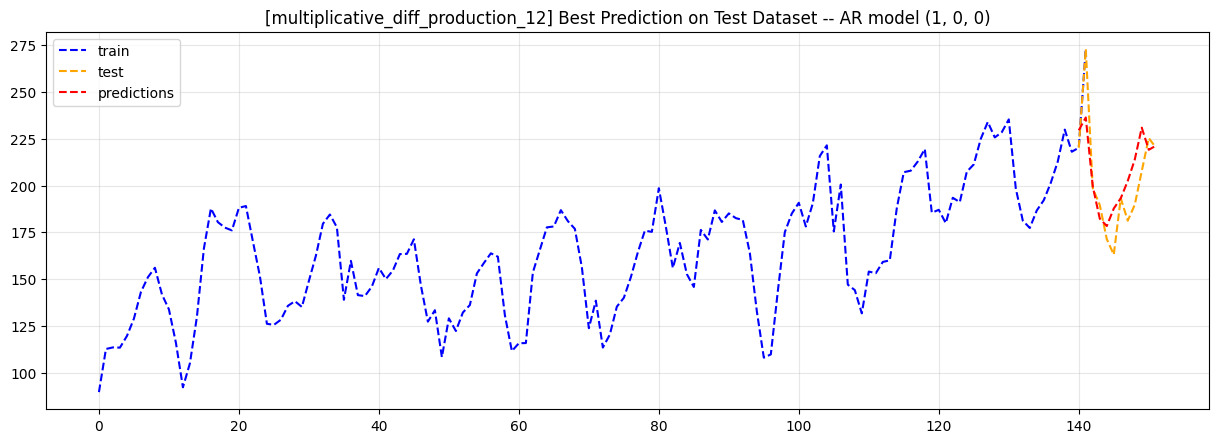

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.09140384438045024,
 '2. Mean Percentage Error (MPE)': 0.0401477098325477,
 '3. Root Mean Squared Error (RMSE)': 20.483502509333587,
 '4. Mean Error (ME)': 8.21344841658769,
 '5. Mean Absolute Error (MAE)': 18.260200518422963,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.8785047703791489}









############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.09148787021331829,
 '2. Mean Percentage Error (MPE)': 0.040302879090860305,
 '3. Root Mean Squared Error (RMSE)

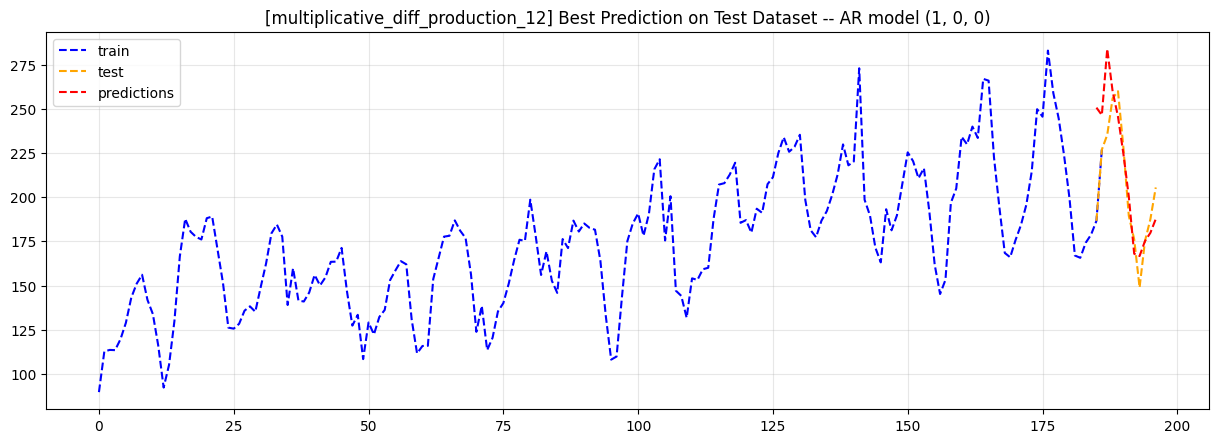

In [818]:
multiplicative_diff_production_12_results_df = test_ARIMA_models(multiplicative_diff_production_12, OtherPEN_production.Log_production,
                                                                 'multiplicative_diff_production_12', show_plots=False, debug_mode=False)

<a id='conclusion'></a>
## Conclusion

### Best Forcasts of Exponential Smoothing Models (based on Cross-Validation)

In [819]:
smoothing_models_results_df

,Iteration,Time_Series_Type,Model_Name,"(smoothing_level, smoothing_trend, smoothing_seasonal)",Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,--,Single Exponential Smoothing,"(0.2, 0, 0)",0.188639,-0.099675,38.190031
1,2,--,Single Exponential Smoothing,"(0.2, 0, 0)",0.128188,0.122019,28.885793
2,3,multiplicative,Multiplicative Triple Exponential Smoothing,"(0.2, 0.2, 0.2)",0.052240,-0.038612,14.451950


### Best Forcasts of AR, MA, ARMA and ARIMA models (based on Cross-Validation)

In [820]:
total_results_df = pd.concat([
    additive_decomposed_production_results_df, multiplicative_decomposed_production_results_df,
    additive_diff_production_1_results_df, multiplicative_diff_production_1_results_df,
    additive_diff_production_12_results_df, multiplicative_diff_production_12_results_df
])
total_results_df

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,additive_decomposed_production,AR model,"(3, 0, 0)",0.070950,0.025781,14.113340
1,2,additive_decomposed_production,MA model,"(0, 0, 2)",0.060372,-0.032329,19.852449
2,3,additive_decomposed_production,AR model,"(4, 0, 0)",0.043599,-0.020567,10.533566
0,1,multiplicative_decomposed_production,AR model,"(3, 0, 0)",0.068701,0.026452,13.851598
1,2,multiplicative_decomposed_production,ARMA model,"(2, 0, 3)",0.059053,-0.022837,20.098636
2,3,multiplicative_decomposed_production,ARMA model,"(4, 0, 3)",0.026988,-0.009899,6.591711
0,1,additive_diff_production_1,ARIMA model,"(4, 2, 2)",0.143152,-0.138944,32.929361
1,2,additive_diff_production_1,ARIMA model,"(4, 1, 4)",0.085398,0.038537,19.254143
2,3,additive_diff_production_1,ARIMA model,"(4, 1, 1)",0.114352,0.085688,28.072150
0,1,multiplicative_diff_production_1,ARMA model,"(1, 0, 1)",0.192613,-0.143039,40.977947


In my case, the best prediction was given by this model:

| Stationary_Series_Name | Model_Name | Model_Orders (p, d, q) | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| multiplicative_decomposed_production | ARMA model| "(4, 0, 3)" | 0.026988 | -0.009899 | 6.591711 |

Here we proved our hypothesis that multiplicative hypothesis will give the best forecast for period of 12 months. Based on cross-validation it gives the best forecasts on second and third iterations.
 Also model with such parameters is pretty close too -- additive_decomposed_production, AR model, "(4, 0, 0)"